In [1]:
'''

Activating session for tensorflow 2 GPU 
Tensroflow 2 with nvidia 3070RTX

''' 
import tensorflow as tf

try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu_instance in physical_devices: 
        tf.config.experimental.set_memory_growth(gpu_instance, True)

    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = tf.compat.v1.Session(config=config)
    set_session(sess)
    print("Using GPU")
except:
    print("Using CPU")

'''

Importing Packages

'''

from PIL import Image    
import os, glob
import sys
import json
import datetime
import numpy as np
import skimage.draw
import shutil
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize as vis
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt


import sys
sys.path.append("../image_augmentation/")
import utils as image_aug_utils





Using CPU


## 1. Loading Dataset

In [4]:
"""Build Dataset."""
print("Loading Training Dataset...")

# Directory in which images exists 
DIR_PATH = "../Annotated_images/wrinkles/"

# Training dataset.
dataset_train = image_aug_utils.GenericDataset()
dataset_train.load_item(DIR_PATH, "train")
dataset_train.prepare()
print("Training Classes ", dataset_train.class_names)

# Validation dataset
print("\n\nLoading Validation Dataset...")
dataset_val = image_aug_utils.GenericDataset()
dataset_val.load_item(DIR_PATH, "val")
dataset_val.prepare()
print("Validation Classes ", dataset_val.class_names)

Loading Training Dataset...
32
Training Classes  ['BG', '1']


Loading Validation Dataset...
8
Validation Classes  ['BG', '1']



## 3. Ploting samples

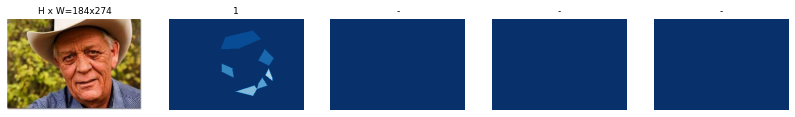

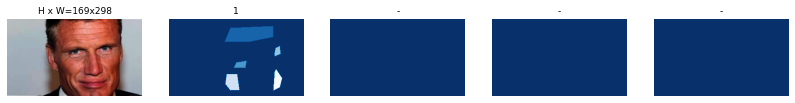

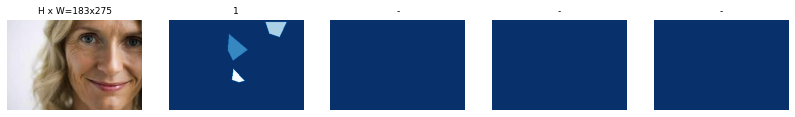

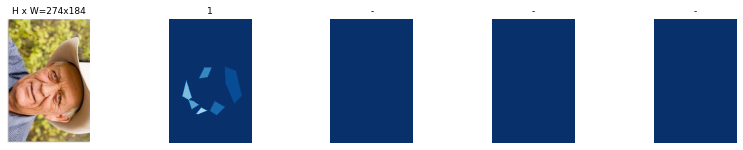

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
    vis.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=4)

In [6]:
dataset_train.class_names

['BG', '1']

## 3. Training Mrcnn

In [7]:
from mrcnn.config import Config

# Your trained weights will be save here 
WEIGHTS_DIR = "./weights/"

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes + 1
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10


# mention your class and steps here
config = GenericConfig(1, 1000)


model = modellib.MaskRCNN(mode="training", config=config, model_dir=WEIGHTS_DIR)
                



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### We will use Image-net weights for transfer learn

In [ ]:

# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Using TensorFlow backend.
2022-02-06 13:38:28.712770: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-06 13:38:28.713215: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [ ]:

model.train(dataset_train, dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=1000,
        layers='all')